# Grid detection for hemocytometer brightfield microscopy images

Start by loading some images

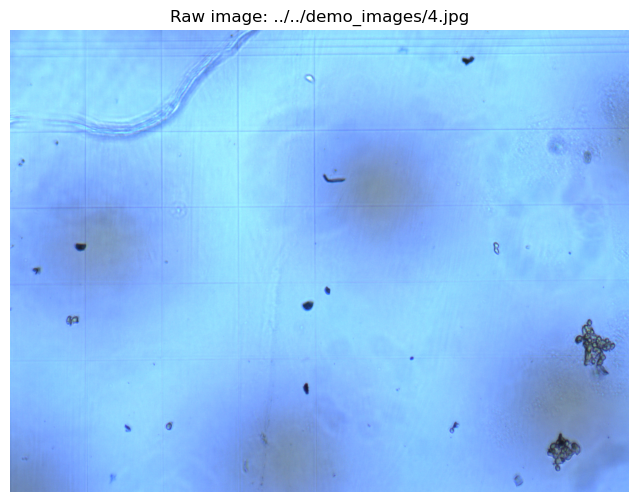

In [66]:
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

# Try a few likely locations (works whether the notebook is run from repo root or from this folder)
candidate_paths = [
    Path("../../demo_images/4.jpg"),
]
image_path = next((p for p in candidate_paths if p.exists()), None)
if image_path is None:
    raise FileNotFoundError(f"Could not find demo image. Tried: {', '.join(map(str, candidate_paths))}")

# Load image (OpenCV reads BGR)
img_bgr = cv2.imread(str(image_path))
if img_bgr is None:
    raise ValueError(f"OpenCV failed to read image: {image_path}")

# add a small rotation to the image
center = (img_bgr.shape[1] // 2, img_bgr.shape[0] // 2)
M = cv2.getRotationMatrix2D(center, angle=0, scale=1.0)
img_bgr = cv2.warpAffine(img_bgr, M, (img_bgr.shape[1], img_bgr.shape[0]))

# Display the raw image
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 6))
plt.imshow(img_rgb)
plt.title(f"Raw image: {image_path}")
plt.axis("off")
plt.show()

### Convert img_rgb to a canny edge detection binary map


Canny thresholds: low=20, high=25


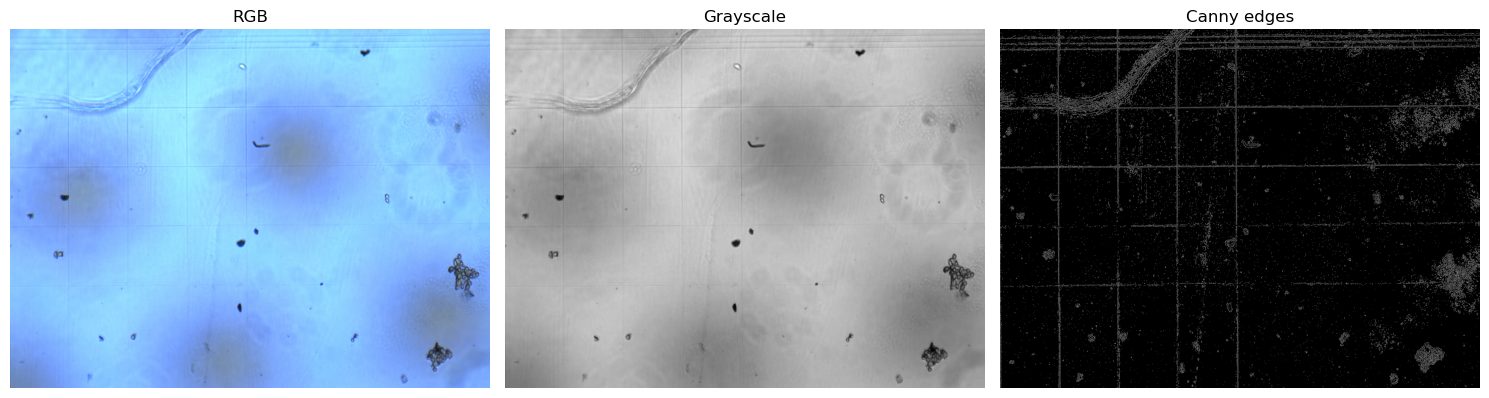

In [67]:
# Convert img_rgb to a Canny edge detection binary map (fixed thresholds for Hough grid lines)
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

# Fixed Canny thresholds (tuned for grid lines; adjust if needed)
canny_low = 20
canny_high = 25
edges = cv2.Canny(img_gray, canny_low, canny_high, apertureSize=3, L2gradient=True)

print(f"Canny thresholds: low={canny_low}, high={canny_high}")

# Display RGB, grayscale (preprocessed), and edges in a matrix
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img_rgb)
axes[0].set_title("RGB")
axes[0].axis("off")

axes[1].imshow(img_gray, cmap="gray")
axes[1].set_title("Grayscale")
axes[1].axis("off")

axes[2].imshow(edges, cmap="gray")
axes[2].set_title("Canny edges")
axes[2].axis("off")

plt.tight_layout()
plt.show()

### Find line equations using Hough's transform

First 3 detected lines (rho, theta):
Line 1: rho=318.00, theta=0.00 radians
Line 2: rho=2.00, theta=0.00 radians
Line 3: rho=958.00, theta=0.00 radians


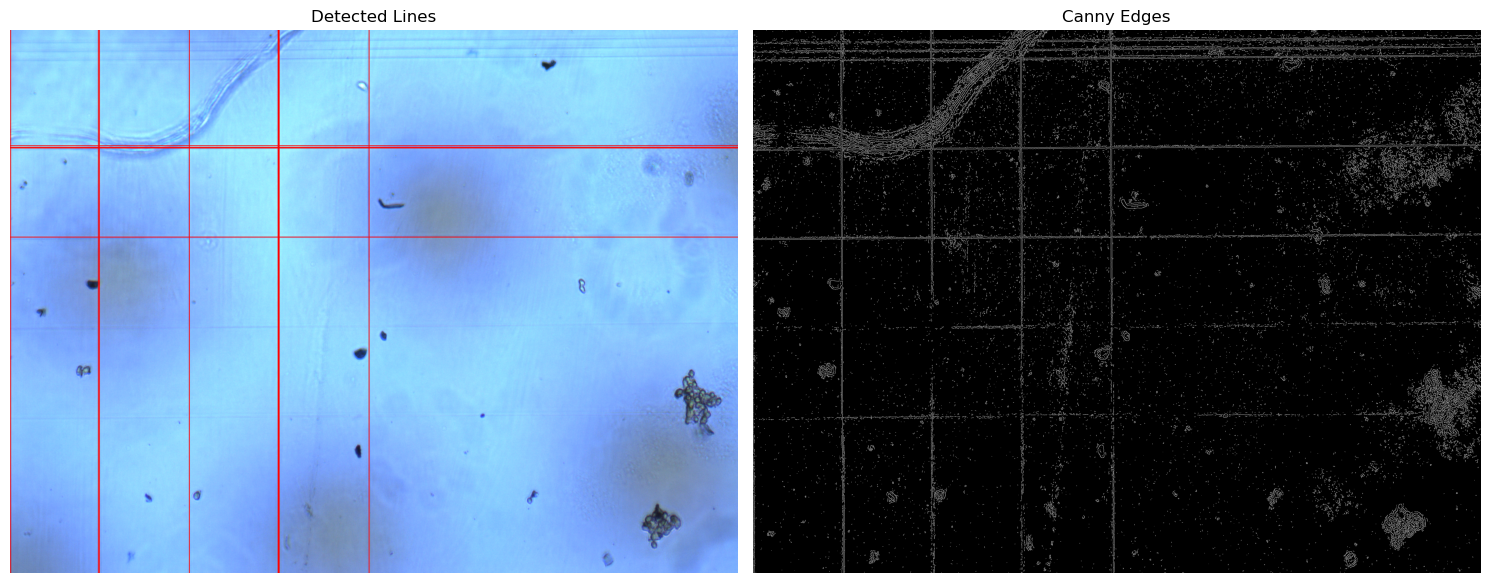

In [68]:
# Find line equations using Hough's transform
import numpy as np

# Get image dimensions
height, width = img_gray.shape
max_dim = max(height, width)
min_dim = min(height, width)

threshold = int(0.25*min_dim)
lines = cv2.HoughLines(edges, 1, np.pi / 180, threshold=threshold)

# Print the first 3 lines detected
if lines is not None:
    print("First 3 detected lines (rho, theta):")
    for i in range(min(3, len(lines))):
        rho, theta = lines[i][0]
        print(f"Line {i+1}: rho={rho:.2f}, theta={theta:.2f} radians")
else:
    print("No lines detected.")

# Visualize detected lines on the original image
img_lines = img_rgb.copy()
if lines is not None:
    for rho, theta in lines[:, 0, :]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        # Create two points far apart to draw an "infinite" line
        x1 = int(round(x0 + max_dim * (-b)))
        y1 = int(round(y0 + max_dim * (a)))
        x2 = int(round(x0 - max_dim * (-b)))
        y2 = int(round(y0 - max_dim * (a)))
        cv2.line(img_lines, (x1, y1), (x2, y2), (255, 0, 0), 2)

# Plot the detected lines overlay and the Canny edges side-by-side
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
axes[0].imshow(img_lines)
axes[0].set_title("Detected Lines")
axes[0].axis("off")
axes[1].imshow(edges, cmap="gray")
axes[1].set_title("Canny Edges")
axes[1].axis("off")
plt.tight_layout()
plt.show()

In [69]:
# Print the number of lines detected
if lines is not None:
    print(f"Total lines detected: {len(lines)}")
else:
    print("No lines detected.")

Total lines detected: 12


Filter away duplicate lines

In [70]:
# Loop through `lines` and remove the lower index lines that are close in rho and theta to higher index lines
if lines is not None:
    filtered_lines = []
    rho_threshold = 15  # Adjust as needed
    theta_threshold = np.deg2rad(5)  # Adjust as needed

    for i in range(len(lines)):
        rho_i, theta_i = lines[i][0]
        too_close = False
        for j in range(i + 1, len(lines)):
            rho_j, theta_j = lines[j][0]
            if abs(rho_i - rho_j) < rho_threshold and abs(theta_i - theta_j) < theta_threshold:
                too_close = True
                break
        if not too_close:
            filtered_lines.append(lines[i])

    print(f"Filtered lines count: {len(filtered_lines)} (from {len(lines)})")
else:
    print("No lines to filter.")

Filtered lines count: 7 (from 12)


## Find squares

Now that we have line candidates in `lines`, it is time to use these line candidates to find the best squares. This will repredent the different detection zones, used for calculating the cell viability per unit of volume in each square.

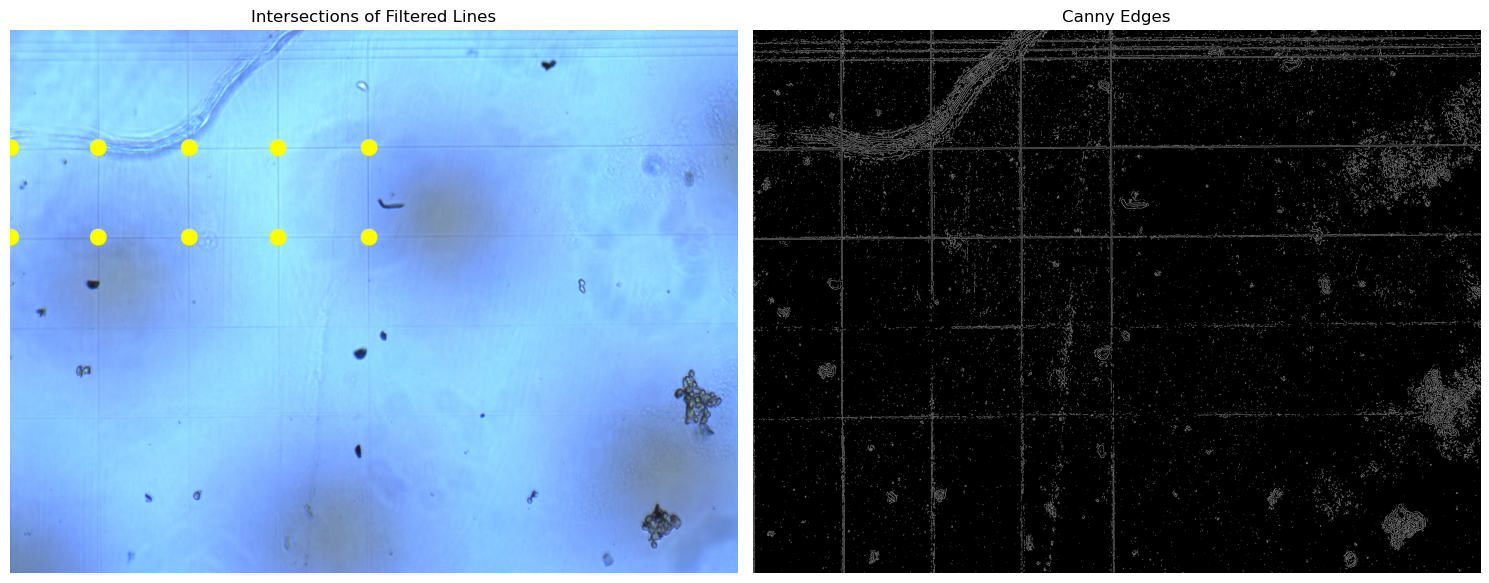

In [71]:
# Display the intersection points of the filtered lines overlayed on the original image
img_intersections = img_rgb.copy()
if lines is not None and len(filtered_lines) >= 2:
    for i in range(len(filtered_lines)):
        rho1, theta1 = filtered_lines[i][0]
        for j in range(i + 1, len(filtered_lines)):
            rho2, theta2 = filtered_lines[j][0]

            # Calculate intersection point
            A = np.array([[np.cos(theta1), np.sin(theta1)],
                          [np.cos(theta2), np.sin(theta2)]])
            b = np.array([[rho1],
                          [rho2]])
            if np.linalg.det(A) != 0:
                x0, y0 = np.linalg.solve(A, b)
                x0, y0 = int(np.round(x0)), int(np.round(y0))
                if 0 <= x0 < img_rgb.shape[1] and 0 <= y0 < img_rgb.shape[0]:
                    cv2.circle(img_intersections, (x0, y0), 30, (255, 255, 0), -1)
# Plot the intersections overlay and the Canny edges side-by-side
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
axes[0].imshow(img_intersections)
axes[0].set_title("Intersections of Filtered Lines")
axes[0].axis("off")
axes[1].imshow(edges, cmap="gray")
axes[1].set_title("Canny Edges")
axes[1].axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# Given these intersection points, we can now attempt to detect squares in the grid.